# Analysis of customer churn for the bank "Metanprom"

## Introduction

Customer churn often poses a threat to the profitability of banks. The reasons for churn are not always obvious, which makes the problem even more acute.

To prevent churn, it is necessary to conduct a detailed analysis of customer data, which will allow conclusions to be drawn about the factors contributing to this phenomenon.

This project aims to identify relevant problematic areas of the bank through the analysis and segmentation of data about departing customers. The project goals include:

1) Studying and preprocessing the dataset of customers.
2) Conducting exploratory data analysis, including creating a portrait of the typical customer.
3) Testing statistical hypotheses about the influence of certain factors on customer churn.
4) Segmenting the data to identify the most churn-prone groups.
5) Providing recommendations regarding the most risky segments.

During the project, an analysis of bank customer data will be conducted. The data consists of 12 columns:

- userid: User identifier
- score: Credit scoring points
- city: City
- gender: Gender
- age: Age
- equity: Approximate assessment of client's property
- balance: Account balance
- products: Number of products used by the client
- credit_card: Presence of a credit card
- last_activity: Whether the client has been active recently
- est_salary: Estimated client salary
- churn: Whether the customer is leaving or not

## Imports and Data Upload

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import warnings
from phik import phik_matrix
from scipy import stats as st


In [2]:
pio.renderers.default = "png"

In [3]:
warnings.simplefilter(action='ignore', category=UserWarning)

### Data Upload

In [4]:
data = pd.read_csv('./datasets/bank_scrooge.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [6]:
data.head(10)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


In the dataset, there are 12 columns, and their types correspond to the data.

Some column names do not adhere to the "snake_case" convention, so we will rename them during the preprocessing stage.

## Data Preprocessing

### Renaming the Columns

In [7]:
data = data.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'})

Now the column names are corrected.

### Missing Values 

In [8]:
data.isna().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

There are missing values in the columns for age and balance. Let's find out if the missing values depend on the data.

In [9]:
def mode_function(x): # function to calculate mode
    modes = x.mode()
    if len(modes) > 0:
        return modes[0]
    else:
        return None

In [10]:
data['age_na'] = 0
data.loc[data['age'].isna() == True, 'age_na'] = 1
data['bal_na'] = 0
data.loc[data['balance'].isna() == True, 'bal_na'] = 1
data.groupby('age_na').agg({'score': 'mean',
                             'city': mode_function, 
                             'gender': mode_function, 
                             'equity': 'mean', 
                             'balance': 'median', 
                             'products': 'mean', 
                             'credit_card': 'mean', 
                             'last_activity': 'mean', 
                             'est_salary': 'median', 
                             'churn': 'mean'})

,score,city,gender,equity,balance,products,credit_card,last_activity,est_salary,churn
age_na,,,,,,,,,,
0,848.682575,Ярославль,М,2.630840,524295.330,1.871466,0.680168,0.522859,119626.795,0.182374
1,855.153846,Ярославль,М,1.384615,417361.115,1.346154,0.769231,0.769231,142598.860,0.038462


It can be noticed that in records with missing age values, departing clients are much less common. Such missing values belong to the MNAR type (missing not at random), so removing them would lead to data distortion. Since it's impossible to recover the values, we'll leave them as they are.

In [11]:
data.groupby('bal_na').agg({'score': 'mean',
                            'city': mode_function, 
                            'gender': mode_function,
                            'age': 'mean', 
                            'equity': 'median', 
                            'products': 'mean', 
                            'credit_card': 'mean', 
                            'last_activity': 'mean', 
                            'est_salary': 'median', 
                            'churn': 'mean'})

,score,city,gender,age,equity,products,credit_card,last_activity,est_salary,churn
bal_na,,,,,,,,,,
0,843.73926,Ярославль,Ж,42.924366,4.0,2.080986,0.640104,0.515769,106222.20,0.234523
1,865.35207,Ярославль,М,42.093023,0.0,1.162092,0.815686,0.549455,174160.68,0.005664


The number of departing clients with missing balance values is also significantly lower. In this case, the type of missingness is not random, so they cannot be discarded.

### Duplicates

We will check the data for duplicates based on the user identifier - this way we can find clients who appear more than once.

In [12]:
data[data['user_id'].duplicated(keep=False) == True].sort_values(by='user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,bal_na
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,0,0
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,0,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,0,1
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,0,0
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1,0,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1,0,0
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0,0,0
6457,228075,839.0,Рыбинск,М,39.0,5,507199.85,3,0,1,85195.80,0,0,0


We notice that users with duplicated user_ids are located in different cities and have different data. Apparently, for each city, user identification is unique. Such values should not be deleted as they are not duplicates. Let's conduct a check for duplicates based on user_id and city together.

In [13]:
data[['user_id', 'city']].duplicated().sum()

0

Indeed, there are 0 instances in the data where both the city and the id would be duplicated, confirming the hypothesis of different identification by cities.

### Anomalous Values

In [14]:
def scatter_anomalies(metric, name):
    fig = px.scatter(x=range(len(data[metric])), y=data[metric], opacity=0.5)
    fig.update_layout(title=name + ' - distribution by clients',
                      xaxis_title='Client number',
                      yaxis_title=name)
    fig.show()

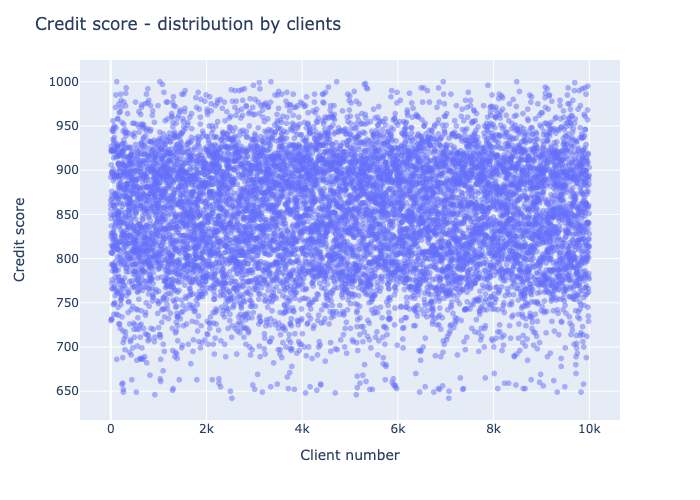

In [15]:
scatter_anomalies('score', 'Credit score')

The scores are distributed approximately from 650 to 1000 without anomalies.

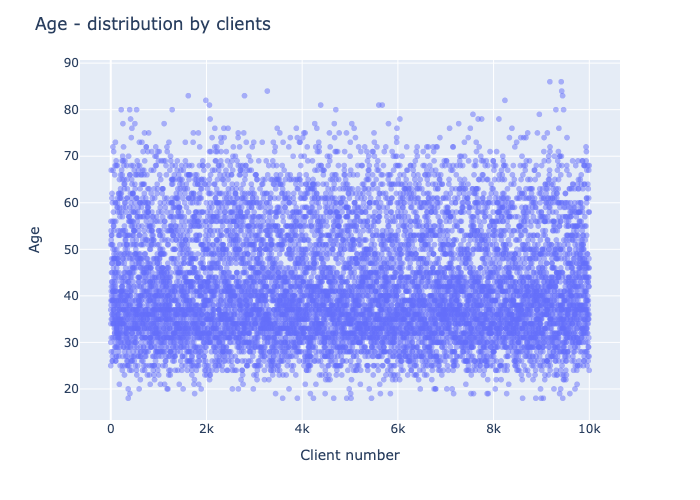

In [16]:
scatter_anomalies('age', 'Age')

The age of clients ranges from 18 to 86, also without anomalies.

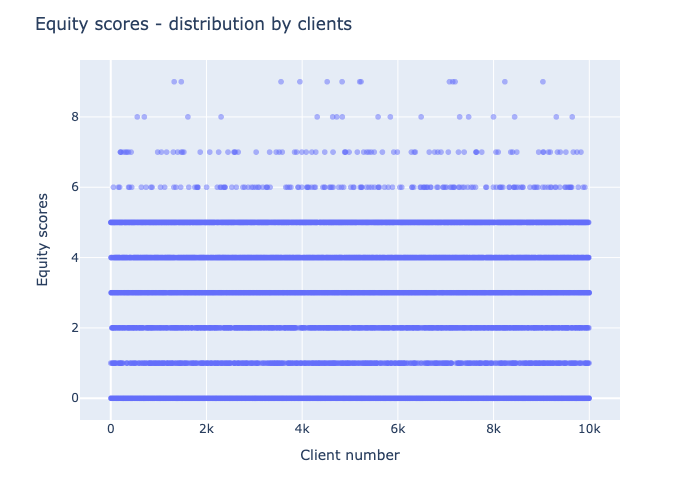

In [17]:
scatter_anomalies('equity', 'Equity scores')

Clients have equity scores ranging from 0 to 9, with no anomalies observed.

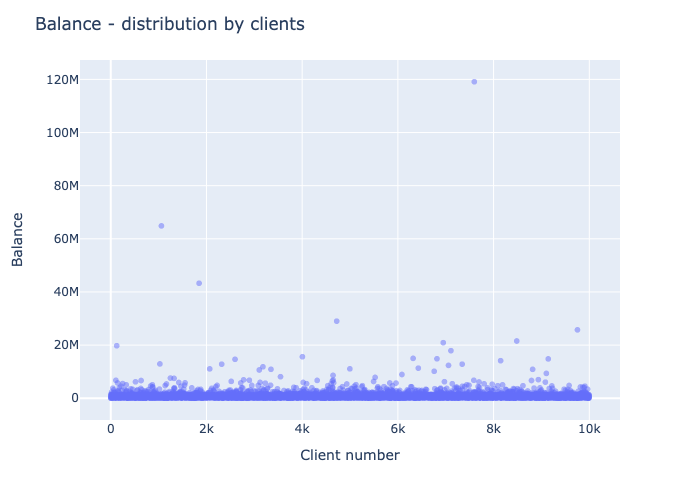

In [18]:
scatter_anomalies('balance', 'Balance')

Most clients have balances of around up to 5 million. However, the wealthiest user has almost 120 million in their account. This value cannot be considered an anomaly because it is realistic for a client to have such a large amount of money.

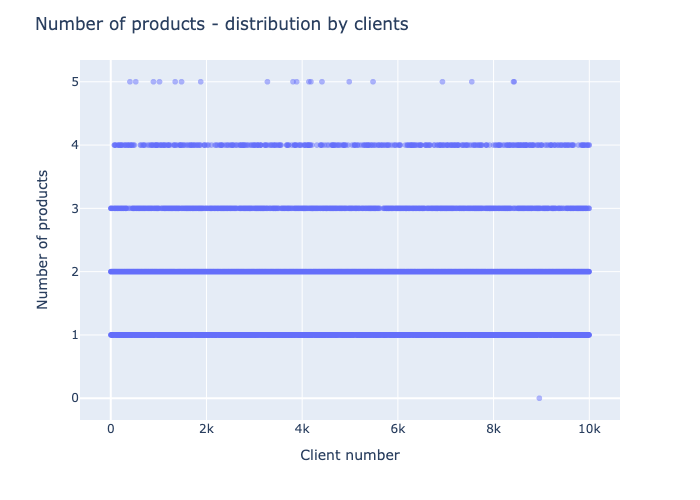

In [19]:
scatter_anomalies('products', 'Number of products')

There is a client with 0 products. Let's check this record in the data.

In [20]:
data[data['products'] == 0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,bal_na
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1,0,1


Since we are dealing with active clients, they should be using at least 1 product. Let's remove this anomaly.

In [21]:
data = data.drop(8957)


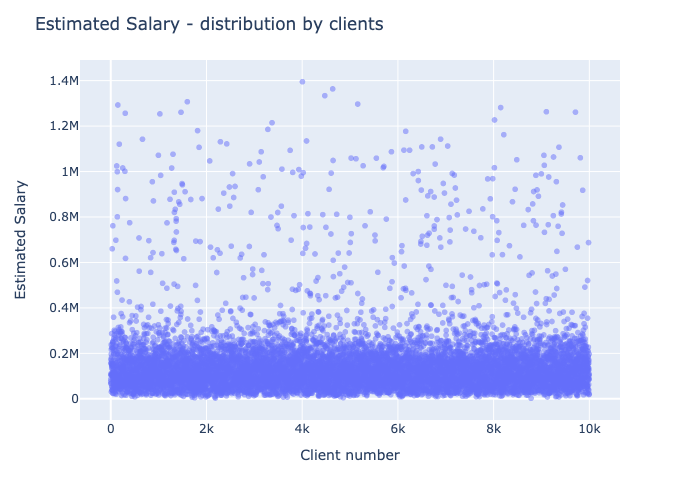

In [22]:
scatter_anomalies('est_salary', 'Estimated Salary')

The estimated salary of clients reaches almost 1.4 million. No anomalies are observed.<br>

As a result of preprocessing, 1 anomaly was deleted from the data.

### Variable Encoding

For correlation analysis, it's necessary to encode categorical variables. Let's add columns with encoded values to the dataset.

In [23]:
data['city_full'] = data['city']
data['gender_full'] = data['gender']
data = pd.get_dummies(data, columns=['city', 'gender'], dtype=int)
data.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_na,bal_na,city_full,gender_full,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,183012,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,0,Рыбинск,Ж,0,1,0,1,0
1,146556,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,0,Рыбинск,Ж,0,1,0,1,0
2,120722,892.0,30.0,0,NaN,1,1,1,107683.34,0,0,1,Рыбинск,Ж,0,1,0,1,0
3,225363,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,Ярославль,Ж,0,0,1,1,0
4,157978,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,Ярославль,М,0,0,1,0,1


The encoding of the columns "city" and "gender" has been completed. The data is ready for analysis.

### Preprocessing Result

As a result of data preprocessing:

- The dataset columns were converted to "snake_case".
- Missing values were found in the age and balance columns of clients. It was determined that these missing values are characteristic of users who are not leaving the bank, so they were left in the dataset.
- Duplicates were found based on user IDs, indicating different data but resulting from separate numbering by cities.
- 1 anomalous value was removed.
- Categorical columns were encoded.

## Exploratory Data Analysis

### Calculating the number of departing clients

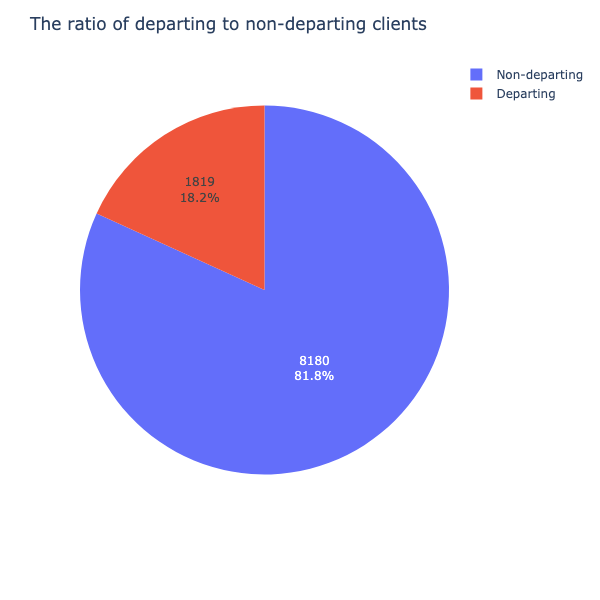

In [24]:
fig1 = px.pie(data['churn'].value_counts(), names=['Non-departing', 'Departing'], values=data['churn'].value_counts())
fig1.update_layout(title='The ratio of departing to non-departing clients',
                   width=600,
                   height=600)
fig1.update_traces(textposition='inside', textinfo='value+percent')
fig1.show()

Among the bank's clients, 1820 are considering leaving, which constitutes 18.2% of the total.

### Typical Client's Portrait

In [25]:
portraits = data.groupby('churn').agg({'score': 'mean',
                                       'city_full': mode_function,
                                       'gender_full': mode_function,
                                       'age': 'median',
                                       'equity': 'median',
                                       'balance': 'mean',
                                       'products': 'median',
                                       'credit_card': 'mean',
                                       'last_activity': 'mean',
                                       'est_salary': 'mean'
                                       })
portraits['balance_median'] = data.groupby('churn').agg({'balance': 'median'})
portraits['est_salary_median'] = data.groupby('churn').agg({'est_salary': 'median'})
portraits = portraits.T
portraits['difference_percentage'] = round((pd.to_numeric(portraits[1], errors='coerce') 
                                            - pd.to_numeric(portraits[0], errors='coerce')) / pd.to_numeric(portraits[0], errors='coerce') * 100, 2)
portraits

churn,0,1,difference_percentage
score,845.428362,863.346894,2.12
city_full,Ярославль,Ярославль,NaN
gender_full,Ж,М,NaN
age,40.0,39.0,-2.50
equity,3.0,4.0,33.33
balance,733982.585648,1133993.27145,54.50
products,2.0,2.0,0.00
credit_card,0.709169,0.551402,-22.25
last_activity,0.483741,0.702584,45.24
est_salary,147783.200108,148310.728202,0.36


It's worth noting that there is a significant difference in the account balances between departing and non-departing clients. The balance of the departing segment is on average 54% higher (with a median balance higher by 65%). Additionally, departing clients are 22% less likely to have credit cards, but their recent activity is on average 45% higher. Moreover, men tend to depart more often than women.

### Distributions Analysis

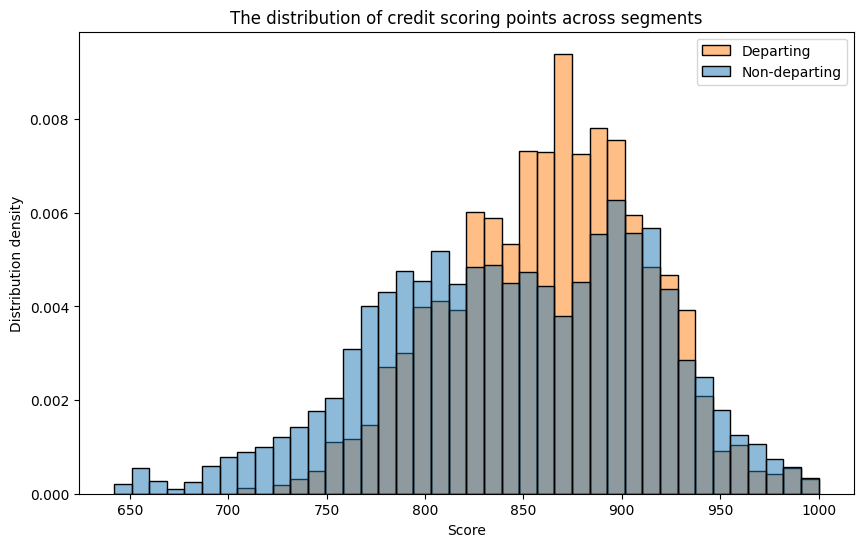

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(data, x='score', stat='density', common_norm=False, hue='churn')
plt.title('The distribution of credit scoring points across segments')
plt.ylabel('Distribution density')
plt.xlabel('Score')
plt.legend(['Departing', 'Non-departing'])
plt.show()

The credit scoring of departing clients is densely distributed around the median in the range between 850-900 points.
The scoring of non-departing clients is more evenly distributed, mostly falling in the range from 750 to 950 points.
Departing clients have higher scoring. In the range of 830-910 points, there are more departing clients than those who stay.

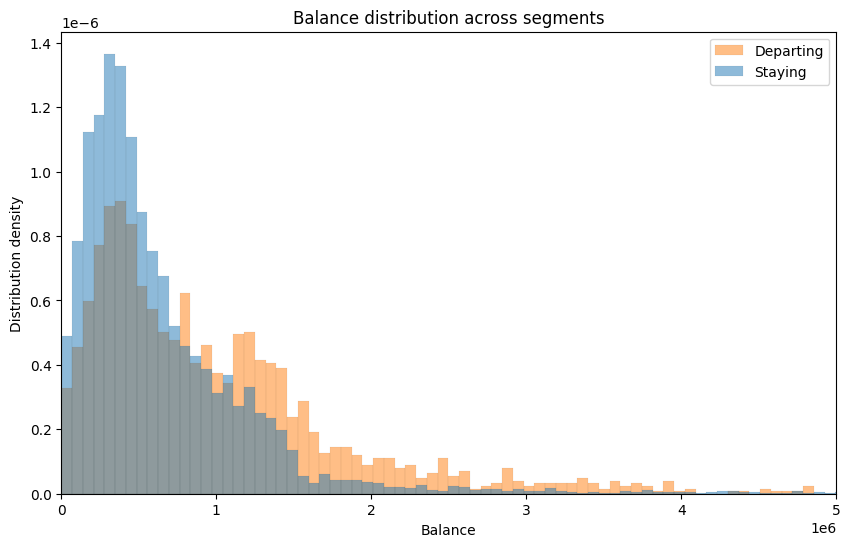

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data, x='balance', stat='density', common_norm=False, hue='churn')
plt.xlim(0, 5000000)
plt.title('Balance distribution across segments')
plt.ylabel('Distribution density')
plt.xlabel('Balance')
plt.legend(['Departing', 'Staying'])
plt.show()

For the staying clients, the balance is tightly distributed around the median of about 300-400 thousand. However, for departing clients, in addition to this peak, there are peaks around 800 thousand and 1.2 million.

Among the departing clients, many have high balances. Starting from a balance of 1.2 million, the distribution of departing clients is higher than that of staying clients.

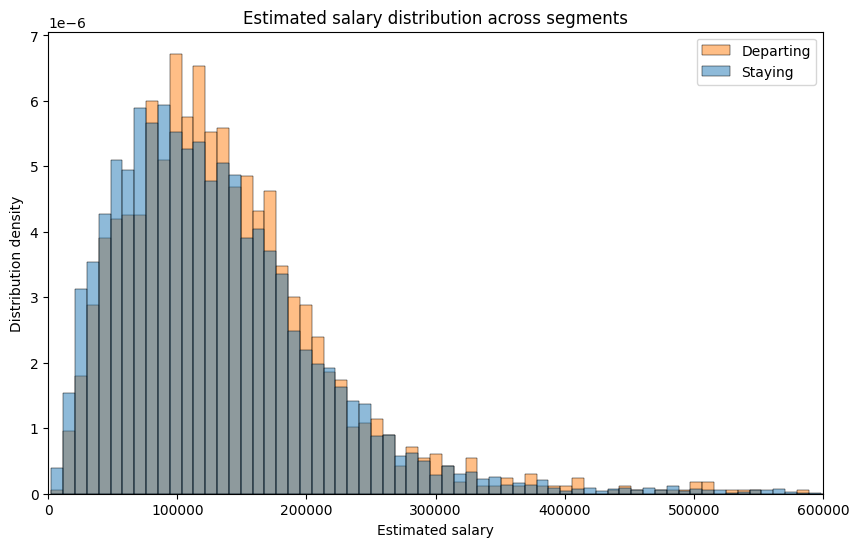

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(data, x='est_salary', stat='density', common_norm=False, hue='churn')
plt.xlim(0, 600000)
plt.title('Estimated salary distribution across segments')
plt.ylabel('Distribution density')
plt.xlabel('Estimated salary')
plt.legend(['Departing', 'Staying'])
plt.show()

The estimated salary is distributed similarly in both segments, with a median around 100,000. However, there is a shift to the right for departing clients. In the range of 100-220 thousand, the distribution of departing clients is higher.

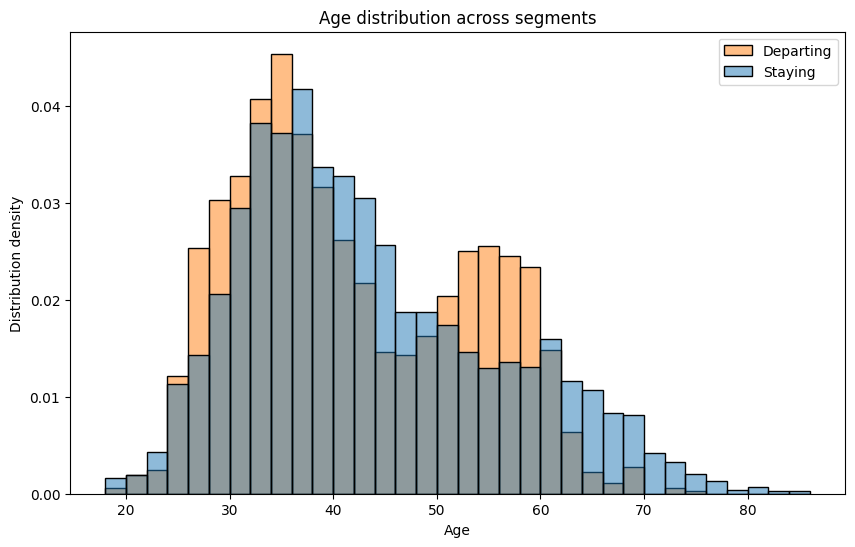

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data, x='age', stat='density', common_norm=False, hue='churn', binwidth=2)
plt.title('Age distribution across segments')
plt.ylabel('Distribution density')
plt.xlabel('Age')
plt.legend(['Departing', 'Staying'])
plt.show()

The majority of staying clients are in the age range of 30-40 years, while departing clients are densely distributed with two peaks around the ages of 35 years and 50-60 years. Among departing clients, there are many middle-aged individuals. In the age ranges of 24-36 and 50-60 years, there are more departing clients than staying clients.

### Categorical Data

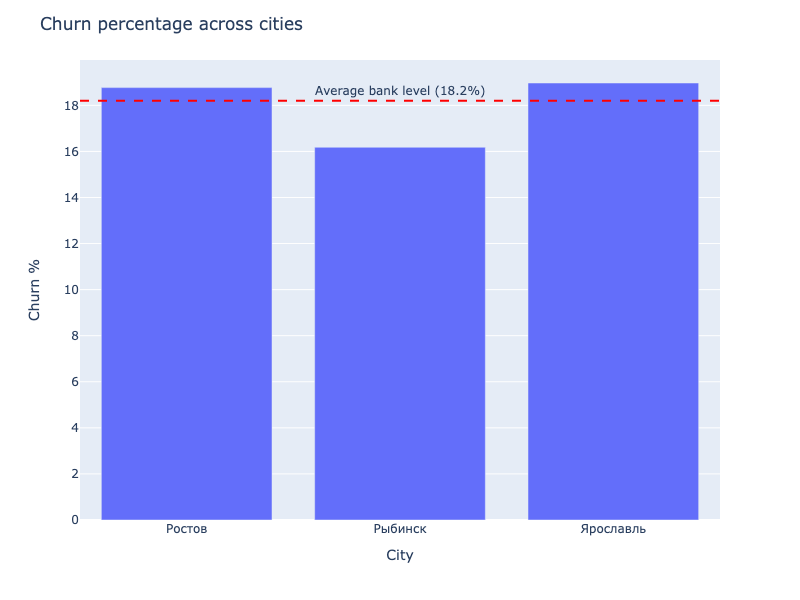

In [30]:
city_churn = data.groupby('city_full').agg({'user_id': 'count', 'churn': 'sum'}).rename(columns={'user_id': 'total_count'})
city_churn['churn_percentage'] = round(city_churn['churn'] / city_churn['total_count'] * 100, 2)
fig2 = px.bar(city_churn['churn_percentage'])
fig2.update_layout(width=800,
                   height=600,
                   title='Churn percentage across cities',
                   xaxis_title='City',
                   yaxis_title='Churn %',
                   showlegend=False)
fig2.add_hline(y=18.2, line_dash="dash", line_color="red")
fig2.add_annotation(
    xref='paper',
    x=0.5, y=18.2,
    text="Average bank level (18.2%)",
    showarrow=False,
    yshift=10
)
fig2.show()

In Rybinsk, the churn rate is 2% lower than the bank's average. In Rostov and Yaroslavl, the churn rate is slightly higher than the average.

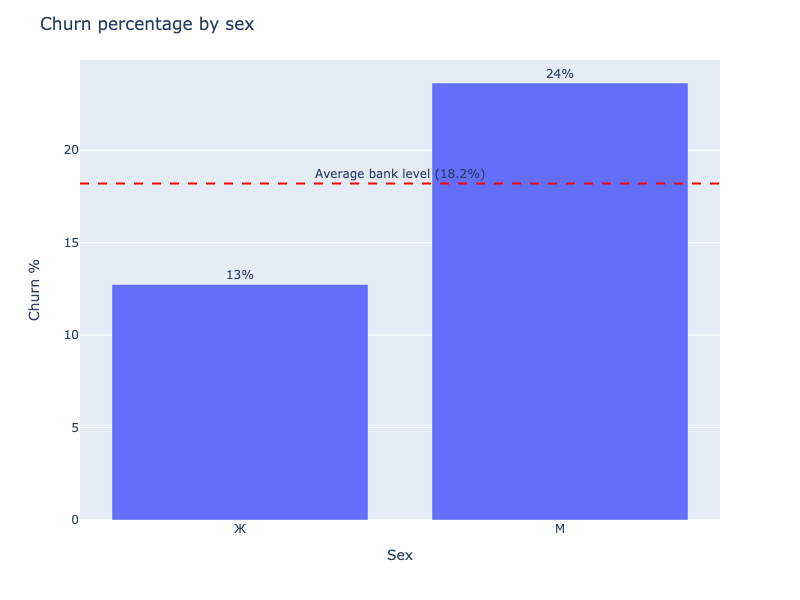

In [31]:
gender_churn = data.groupby('gender_full').agg({'user_id': 'count', 'churn': 'sum'}).rename(columns={'user_id': 'total_count'})
gender_churn['churn_percentage'] = round(gender_churn['churn'] / gender_churn['total_count'] * 100, 2)
fig3 = px.bar(gender_churn['churn_percentage'], text=gender_churn['churn_percentage'])
fig3.update_layout(width=800,
                   height=600,
                   title='Churn percentage by sex',
                   xaxis_title='Sex',
                   yaxis_title='Churn %',
                   showlegend=False)
fig3.add_hline(y=18.2, line_dash="dash", line_color="red")
fig3.add_annotation(
    xref='paper',
    x=0.5, y=18.2,
    text="Average bank level (18.2%)",
    showarrow=False,
    yshift=10
)
fig3.update_traces(texttemplate='%{text:.2s}%', textposition='outside')
fig3.show()

It's worth noting that among females, the churn rate is significantly lower (with a difference of more than 5%). Among males, the churn rate is above average by approximately 6%.

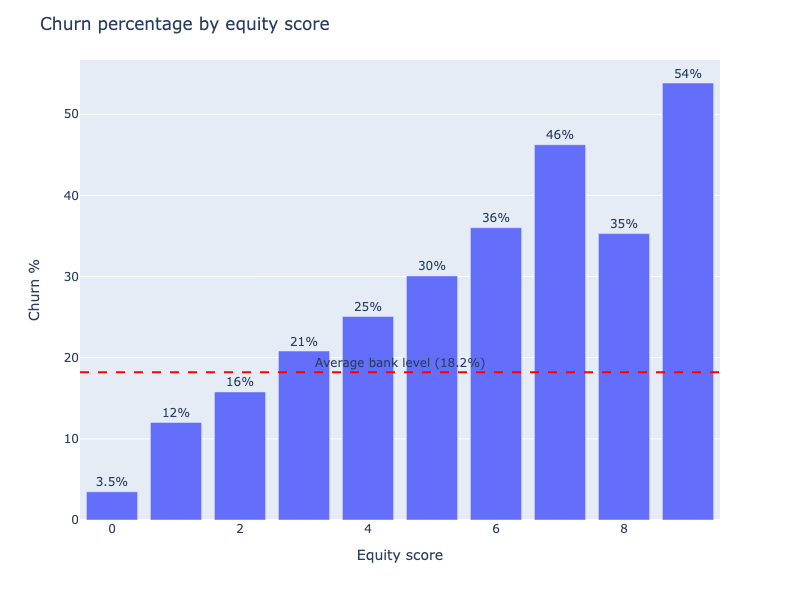

In [32]:
equity_churn = data.groupby('equity').agg({'user_id': 'count', 'churn': 'sum'}).rename(columns={'user_id': 'total_count'})
equity_churn['churn_percentage'] = round(equity_churn['churn'] / equity_churn['total_count'] * 100, 2)
fig4 = px.bar(equity_churn['churn_percentage'], text=equity_churn['churn_percentage'])
fig4.update_layout(width=800,
                   height=600,
                   title='Churn percentage by equity score',
                   xaxis_title='Equity score',
                   yaxis_title='Churn %',
                   showlegend=False)
fig4.add_hline(y=18.2, line_dash="dash", line_color="red")
fig4.add_annotation(
    xref='paper',
    x=0.5, y=18.2,
    text="Average bank level (18.2%)",
    showarrow=False,
    yshift=10
)
fig4.update_traces(texttemplate='%{text:.2s}%', textposition='outside')
fig4.show()

It can be observed that most of the staying bank clients have 0 equity points, and only a few of them have between 1 to 6 points. Departing clients, on the other hand, mostly have between 3 to 5 points. Departing clients tend to have more equity. In the range from 3 to 9 points, the churn rate exceeds the bank's average, increasing as the equity increases.

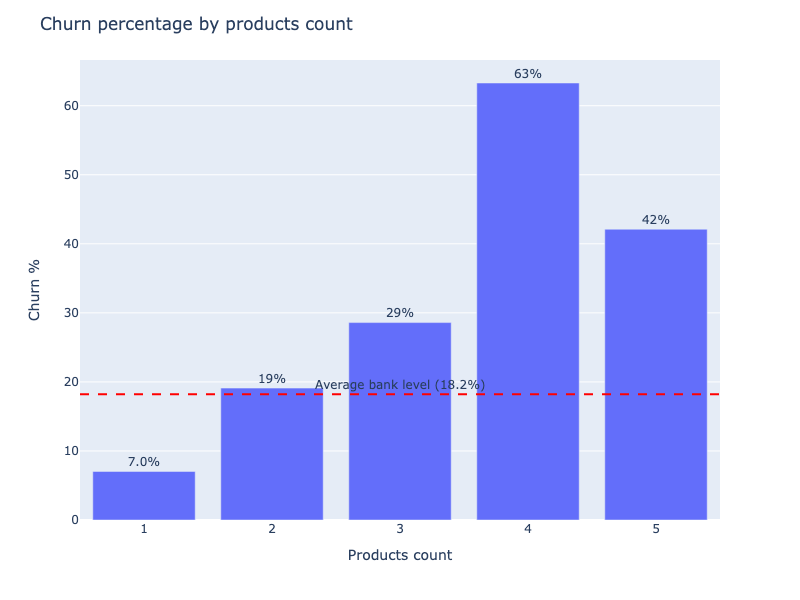

In [33]:
products_churn = data.groupby('products').agg({'user_id': 'count', 'churn': 'sum'}).rename(columns={'user_id': 'total_count'})
products_churn['churn_percentage'] = round(products_churn['churn'] / products_churn['total_count'] * 100, 2)
fig5 = px.bar(products_churn['churn_percentage'], text=products_churn['churn_percentage'])
fig5.update_layout(width=800,
                   height=600,
                   title='Churn percentage by products count',
                   xaxis_title='Products count',
                   yaxis_title='Churn %',
                   showlegend=False)
fig5.add_hline(y=18.2, line_dash="dash", line_color="red")
fig5.add_annotation(
    xref='paper',
    x=0.5, y=18.2,
    text="Average bank level (18.2%)",
    showarrow=False,
    yshift=10
)
fig5.update_traces(texttemplate='%{text:.2s}%', textposition='outside')
fig5.show()

Among clients using more than two products, the churn rate significantly exceeds the bank's average. Clients with one product are most likely to stay in the bank, while among clients with four products, a whopping 63% are departing.

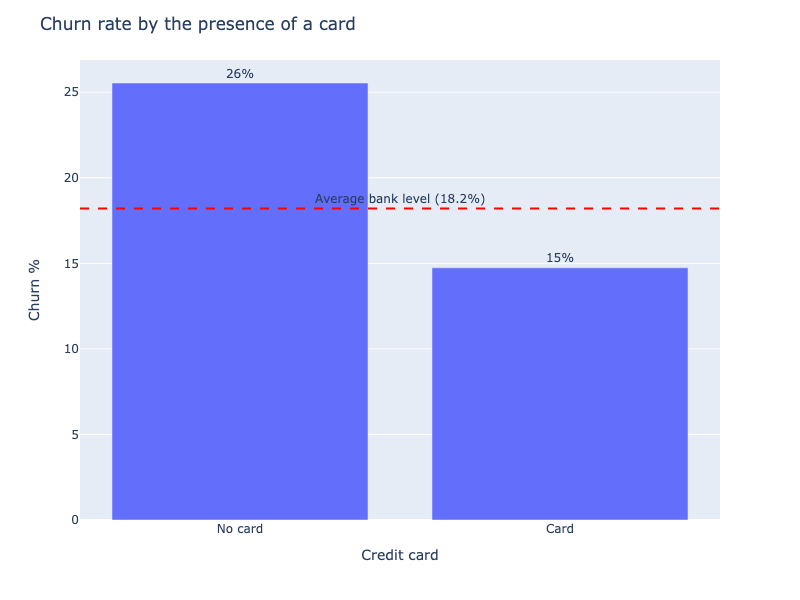

In [34]:
card_churn = data.groupby('credit_card').agg({'user_id': 'count', 'churn': 'sum'}).rename(columns={'user_id': 'total_count'})
card_churn['churn_percentage'] = round(card_churn['churn'] / card_churn['total_count'] * 100, 2)
fig6 = px.bar(card_churn['churn_percentage'], text=card_churn['churn_percentage'])
fig6.update_layout(width=800,
                   height=600,
                   title='Churn rate by the presence of a card',
                   xaxis_title='Credit card',
                   yaxis_title='Churn %',
                   showlegend=False)
fig6.add_hline(y=18.2, line_dash="dash", line_color="red")
fig6.add_annotation(    
    xref='paper',
    x=0.5, y=18.2,
    text="Average bank level (18.2%)",
    showarrow=False,
    yshift=10
)
fig6.update_xaxes(tickvals=[0, 1],
                  ticktext=['No card', 'Card'])
fig6.update_traces(texttemplate='%{text:.2s}%', textposition='outside')
fig6.show()

Clients without a credit card are less likely to stay with the bank, with their churn rate approximately 8% higher than average. Clients with a card have a churn rate below average by more than 3%.

This phenomenon can be explained by increased retention through credit cards. Banks often raise credit limits and overall create more favorable credit conditions for such clients, which gives them greater incentive to continue using the services.

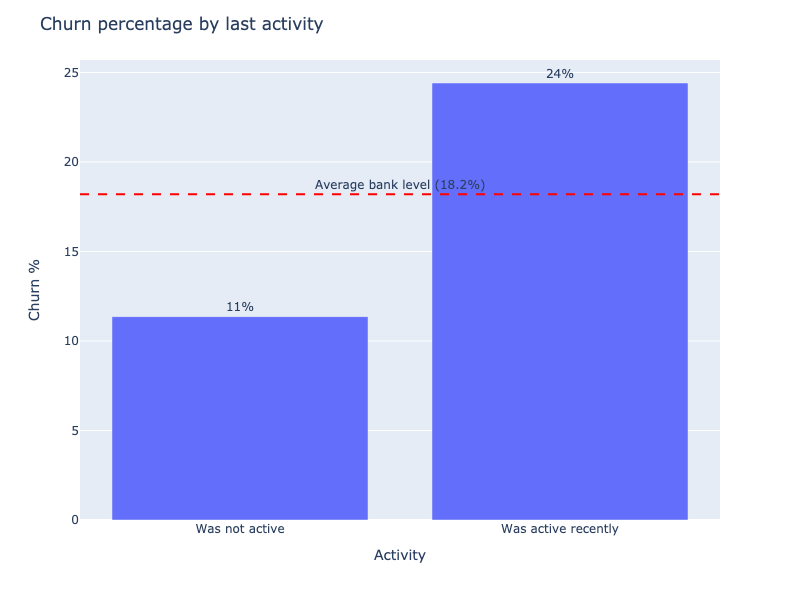

In [35]:
activity_churn = data.groupby('last_activity').agg({'user_id': 'count', 'churn': 'sum'}).rename(columns={'user_id': 'total_count'})
activity_churn['churn_percentage'] = round(activity_churn['churn'] / activity_churn['total_count'] * 100, 2)
fig7 = px.bar(activity_churn['churn_percentage'], text=activity_churn['churn_percentage'])
fig7.update_layout(width=800,
                   height=600,
                   title='Churn percentage by last activity',
                   xaxis_title='Activity',
                   yaxis_title='Churn %',
                   showlegend=False)
fig7.add_hline(y=18.2, line_dash="dash", line_color="red")
fig7.add_annotation(    
    xref='paper',
    x=0.5, y=18.2,
    text="Average bank level (18.2%)",
    showarrow=False,
    yshift=10
)
fig7.update_xaxes(tickvals=[0, 1],
                  ticktext=['Was not active', 'Was active recently'])
fig7.update_traces(texttemplate='%{text:.2s}%', textposition='outside')
fig7.show()

Clients who have been active recently are more likely to leave the bank. Their churn rate is 6% higher than average. On the other hand, clients without recent activity depart less frequently, with a churn rate of 11%, which is 7% below average.

### Correlational Analysis

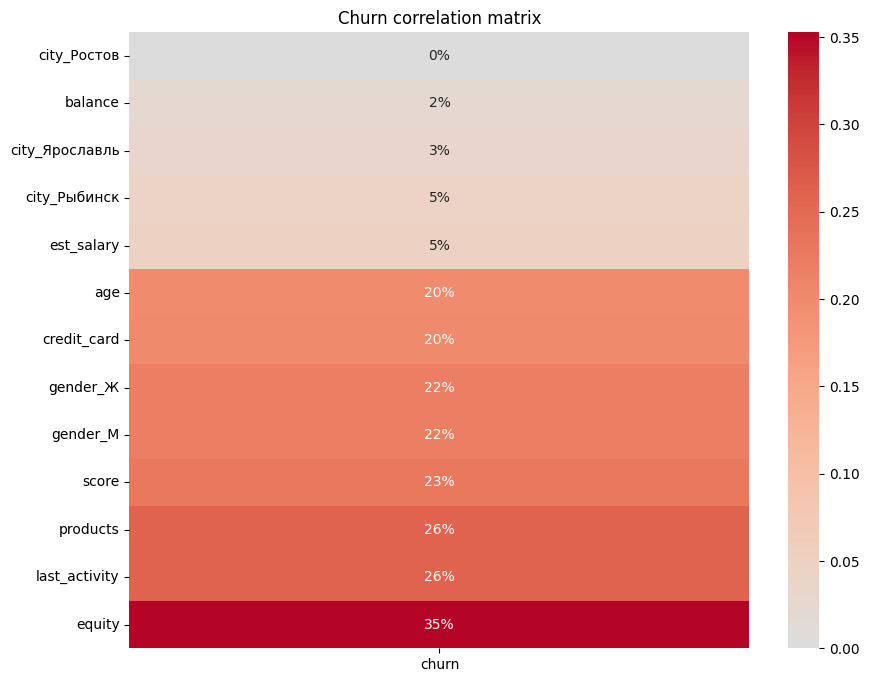

In [36]:
matrix = data.drop(columns=['user_id', 'city_full', 'gender_full', 'age_na', 'bal_na']).phik_matrix(interval_cols=['score', 'balance', 'est_salary'])
plt.figure(figsize=(10, 8))
sns.heatmap(matrix.loc[:, ['churn']].drop('churn').sort_values('churn'), 
            annot=True, 
            fmt=".0%", 
            cmap='coolwarm', 
            center=0)
plt.title("Churn correlation matrix")
plt.show()

According to the Chaddock's scale, the correlation of all features, except for equity points and the number of products, with churn is weak (correlation coefficient below 0.3).

The correlation of equity points and the number of products with churn is moderate (0.35 and 0.44 respectively).

### Results of Exploratory Analysis

The results of the exploratory data analysis reveal the following insights:

- 18.2% of the bank's customers are considering leaving.
- The balance of departing customers is, on average, 54% higher.
- Departing customers are 22% less likely to have credit cards, but their recent activity is 45% higher on average.
- Churned customers have higher credit scores.
- The balance distribution for departing customers peaks around 800k and 1.2 million, besides the primary peak around 300-400k.
- Estimated salaries are similarly distributed in both segments, with a median around 100k, but churned customers tend to have higher salaries.
- Among churned customers, there are many middle-aged individuals.
- Most remaining customers have 0 equity points, while departing customers typically have 3 to 5 points.
- The majority of churned customers use three bank products, with some having four or five. Remaining customers typically use two products.
- In Rybinsk, the churn rate is 2% lower than the bank average, while it is slightly higher in Rostov and Yaroslavl.
- Churn rates are significantly lower among female customers (difference of over 5%). Among males, the churn rate is approximately 6% higher than average.
- Customers without credit cards are less likely to stay, with a churn rate approximately 8% higher than average. Customers with credit cards have a churn rate over 3% lower than average.
- Customers who have been active recently are more likely to churn, with a churn rate 6% higher than average. Customers without recent activity are less likely to churn, with a churn rate 7% lower than average.
- The correlation of all features with churn, except for equity points and the number of products, is weak (correlation coefficient below 0.3). The correlation of equity points and the number of products with churn is moderate (0.35 and 0.44, respectively).

**Portrait of a Non-Churned Customer:**
- Average credit score: 845
- Most common city: Yaroslavl
- Gender: Female
- Average age: 40 years
- Equity points: 3
- Average balance: 734k (median: 475k)
- Number of bank products: 2
- Has a credit card
- Not recently active
- Average estimated salary: 148k (median: 118k)

**Portrait of a Churned Customer:**
- Average credit score: 863 (More churned customers fall in the range of 830-910 credit score)
- Most common city: Yaroslavl
- Gender: Male (Churn rate among males is approximately 6% higher than average)
- Average age: 39 years (More churned customers fall in the age range of 24-36 and 50-60 years)
- Equity points: 4 (Churn rate increases with higher equity points)
- Average balance: 1.134 million (median: 782k) (Churn rate increases significantly for balances above 1.2 million)
- Number of bank products: 2 (Churn rate is significantly higher for customers using more than two products)
- Has a credit card (Churn rate is higher for customers without credit cards)
- Recently active (Churn rate is higher for recently active customers)
- Average estimated salary: 148k (median: 125k) (Churn rate is higher for customers with salaries between 100k-220k)

## Testing of Statistical Hypotheses

### Hypothesis 1

To use the Student's t-test, the following conditions should be met:

- Data should be normally distributed.
- Variances in the data should be equal (though you can set the parameter `equal_var=False` if variances differ).
- The data should be quantitative.
- It can be used with samples of different sizes, but it's important to check small samples for normality.

On the other hand, for the Mann-Whitney U-test:

- Data does not need to follow a normal distribution.
- Samples should be independent.
- Data can be either quantitative or ordinal.
- Samples can have different sizes.

Now let's check the data for normality:

Hypothesis 1.1:

H0 - The salary of the remaining clients is normally distributed.
H1 - The salary of the remaining clients is not normally distributed.

Hypothesis 1.2:

H0 - The salary of the departing clients is normally distributed.
H1 - The salary of the departing clients is not normally distributed.

In [37]:
alpha = 0.05
salary_A = data.loc[data['churn'] == 0, 'est_salary']
salary_B = data.loc[data['churn'] == 1, 'est_salary']

print('Statistical significance:', alpha)
print()
print('Testing hypothesis 1.1:')
p_value1 = st.shapiro(salary_A)[1]
print('P-value:', p_value1)
if p_value1 < alpha:
    print('The null hypothesis is rejected: the distribution is not normal.')
else:
    print('The null hypothesis cannot be rejected: the distribution is normal.')
print()
print('Testing Hypothesis 1.2:')
p_value2 = st.shapiro(salary_B)[1]
print('P-value:', p_value2)
if p_value2 < alpha:
    print('The null hypothesis is rejected: the distribution is not normal.')
else:
    print('The null hypothesis cannot be rejected: the distribution is normal.')

Statistical significance: 0.05

Testing hypothesis 1.1:
P-value: 2.392802738732869e-86
The null hypothesis is rejected: the distribution is not normal.

Testing Hypothesis 1.2:
P-value: 7.41746467436077e-52
The null hypothesis is rejected: the distribution is not normal.


It was found that the salary data is not normally distributed in both groups. Also, the samples have different sizes and a large number of outliers, indicating the need to use the Mann-Whitney U-test. Let's compare the obtained p-value with the level of statistical significance and draw a conclusion.

H0 - The mean salary of the clients remaining in the bank does not differ from the mean salary of the departing clients.
H1 - The mean salary differs between the remaining and departing clients.

In [38]:
print('Statistical significance:', alpha)
p_value_u = st.mannwhitneyu(salary_A, salary_B).pvalue
print('P-value:', p_value_u)
if p_value_u < alpha:
    print('We reject the null hypothesis: there is a significant difference between the mean salaries..')
else:
    print('We failed to reject the null hypothesis; there is no statistically significant difference between the mean salaries..')

Statistical significance: 0.05
P-value: 0.00021160652203623057
We reject the null hypothesis: there is a significant difference between the mean salaries..


### Hypothesis 2

To assess the statistical hypothesis regarding the equality of ages between churned and retained clients:

H0 - There is no significant difference in ages between churned and retained clients.
H1 - There is a difference in ages between churned and retained clients.

First, we need to check the data for normality and decide which test to apply.

Hypothesis 2.1:
H0 - The age distribution of retained clients is normal.
H1 - The age distribution of retained clients is not normal.

Hypothesis 2.2:
H0 - The age distribution of churned clients is normal.
H1 - The age distribution of churned clients is not normal.

In [39]:
age_A = data.loc[data['churn'] == 0, 'age']
age_B = data.loc[data['churn'] == 1, 'age']

print('Statistical significance:', alpha)
print()
print('Testing hypothesis 2.1:')
p_value_1 = st.shapiro(age_A)[1]
print('P-value:', p_value_1)
if p_value_1 < alpha:
    print('The null hypothesis is rejected: the distribution is not normal.')
else:
    print('The null hypothesis cannot be rejected: the distribution is normal.')
print()
print('Testing hypothesis 2.2:')
p_value_2 = st.shapiro(age_B)[1]
print('P-value:', p_value_2)
if p_value_2 < alpha:
    print('The null hypothesis is rejected: the distribution is not normal.')
else:
    print('The null hypothesis cannot be rejected: the distribution is normal.')

Statistical significance: 0.05

Testing hypothesis 2.1:
P-value: 1.0
The null hypothesis cannot be rejected: the distribution is normal.

Testing hypothesis 2.2:
P-value: 1.0
The null hypothesis cannot be rejected: the distribution is normal.


P-value significantly exceeded the level of statistical significance, indicating the normality of the distributions. Therefore, we can apply the Student's t-test to test the hypotheses.

In [40]:
print('Ratio of variances in samples:', np.var(age_A) / np.var(age_B))

Ratio of variances in samples: 1.2335297749800191


The variances differ, so we will set the parameter equal_var to False

In [41]:
print('Statistical significance:', alpha)
p_value_age = st.ttest_ind(age_A, age_B, equal_var=False, nan_policy='omit').pvalue
print('P-value:', p_value_age)
if p_value_age < alpha:
    print('We reject the null hypothesis; there is a difference between the ages of the clients.')
else:
    print('We failed to reject the null hypothesis; no significant difference was found between the ages.')

Statistical significance: 0.05
P-value: 7.536127357312234e-08
We reject the null hypothesis; there is a difference between the ages of the clients.


### Results of Hypotheses Testing

In the course of testing statistical hypotheses, it was established that:

- There is a significant difference in the distribution of salaries between the groups of departing and remaining clients.
- The average age of departing clients differs from the average age of remaining clients.

## Data Segmentation

In [42]:
data.query('equity > 3 & products > 2').agg({'churn': ['mean', 'sum', 'count']})

,churn
mean,0.447009
sum,426.000000
count,953.000000


In the segment of clients who have more than two products and three points of property, there are 953 individuals, 426 of whom are intending to leave. The churn rate for this segment is almost 45%.

In [43]:
data.query('830 <= score <= 900 & balance > 1200000').agg({'churn': ['mean', 'sum', 'count']})

,churn
mean,0.493724
sum,236.000000
count,478.000000


The segment with high balance (over 1.2 million) and credit rating (from 830 to 900) consists of 478 clients, 236 of whom are churned. The churn rate in this segment is over 49%.

In [44]:
data.query('credit_card == 0 & last_activity == 1 & gender_full == "М"').agg({'churn': ['mean', 'sum', 'count']})

,churn
mean,0.419444
sum,302.000000
count,720.000000


Among the clients, there are 720 men without a credit card who recently showed activity. 302 of them are churning, which accounts for an almost 42% churn rate.

### Recommendations for Segments

**Customers with more than 2 products and a property score of 3:**

To retain this segment, it is proposed to offer favorable conditions for property insurance to customers who are already using multiple products. This can be achieved by collaborating with well-known insurance companies that would be interested in loyal bank customers.

**Customers with high credit scores and balances:**

In this case, it is recommended to offer customers favorable terms for new loans or mortgages, as they already have a good credit reputation and have funds in their accounts to pay interest. Additionally, offering credit cards, which as previously determined, positively impact customer retention, could be beneficial.

**Men without credit cards but with recent activity:**

For men actively using the bank, it is necessary to offer credit cards on favorable terms. Such offers can be implemented through notifications in the mobile application, which active users are likely to notice. As mentioned earlier, credit cards play a significant role in customer retention.

## Overall Conclusion and Recommendations

During the work, the data on "Metanprom" bank clients were preprocessed and analyzed. The exploratory analysis helped identify the most important criteria for customer retention and create typical customer portraits. Statistical hypotheses were tested to identify features in the distribution of attributes. At the end of the work, data segmentation was conducted, and the most churn-prone customer groups were identified, allowing recommendations for their retention.

The following patterns were identified:
- 18.2% of the bank's customers are planning to leave.
- The balance of the leaving segment is on average 54% higher.
- Leaving customers are 22% less likely to have credit cards, but their recent activity is on average 45% higher.
- Churning customers have higher credit scores.
- Most staying bank customers have 0 property ownership points, with only some having 1 to 6 points. Leaving customers, on the other hand, mostly have 3 to 5 points.
- Most leaving customers use three bank products, while some have four or five products. Customers staying with the bank more often use 2-3 products.
- Among females, churn is significantly lower (by more than 5%). Among males, the churn rate is above average by approximately 6%.
- Customers without a credit card are less likely to stay with the bank, and their churn rate is approximately 8% above average. Customers with a card have below-average churn by more than 3%.
- Customers who have been active recently are more likely to leave the bank. Their churn rate is above average by 6%. Customers without recent activity, on the contrary, churn less, with their churn rate at 11%, which is 7% below average.
- The correlation of all attributes, except property ownership points and the number of products, with churn is weak (correlation coefficient below 0.3). The correlation of property ownership points and the number of products with churn is moderate (0.35 and 0.44 respectively).

The statistical analysis indicated that:
- There is a significant difference in salary distribution between leaving and staying customer groups.
- The average age of leaving customers differs from the average age of staying customers.

Finally, the following solutions were proposed for retaining the most churn-prone groups:

<b>Customers with more than 2 products and 3 property ownership points:</b>

To retain this segment, it is proposed to offer customers who already use multiple products favorable conditions for property insurance. This can be achieved through cooperation with well-known insurance companies interested in loyal bank customers.

<b>Customers with high credit scores and balances:</b>

In this case, it is recommended to offer customers favorable conditions for a new loan or mortgage, as they already have a good credit reputation and funds in their account to pay interest. Credit cards can also be offered, as previously found, they have a positive effect on customer retention.

<b>Men without credit cards with recent activity:</b>

For men actively using the bank's services, it is necessary to offer credit cards on favorable terms. Such an offer can be implemented through notifications in the mobile application, which will definitely be noticed by active users. As mentioned earlier, credit cards contribute significantly to customer retention.